In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy.fft import dct, idct

#plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [61]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [62]:
k = 100 # Top 10% highest l2-magnitude filters

In [63]:
filters.shape

(3, 3, 256, 256)

tf.Tensor(0.011013093, shape=(), dtype=float32)
tf.Tensor(0.011013093, shape=(), dtype=float32)
tf.Tensor(
[[0.294399   0.3537655  0.04080085]
 [0.1984158  0.00358355 0.01617071]
 [0.07216474 0.00472804 0.01597191]], shape=(3, 3), dtype=float32)
0
1
2
3
4
5
6
7
8
9
10
11
12


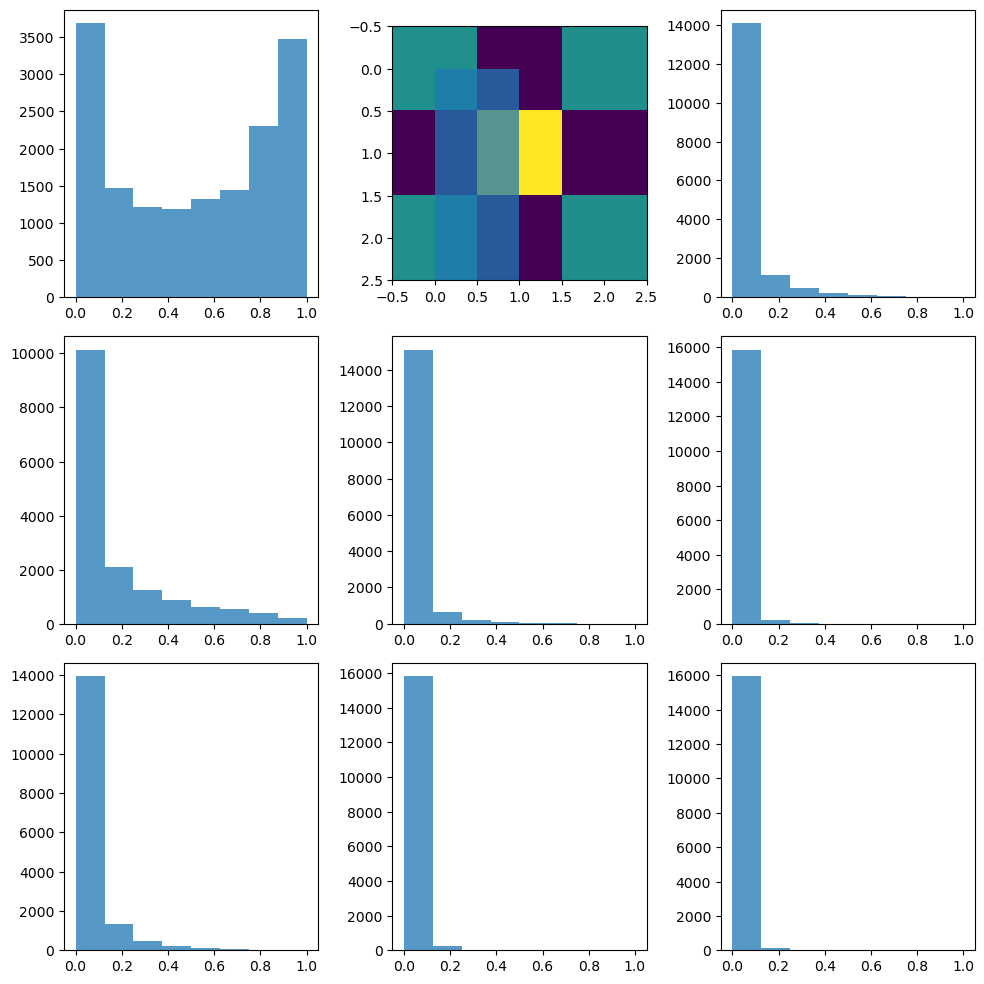

array([[-0.04380478, -0.00314543,  0.00360923],
       [-0.00013947, -0.000857  ,  0.00280553],
       [-0.00036641,  0.00241681, -0.00052584]], dtype=float32)

In [64]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)

top3_coef_mag = []
kernel_mag = []


top10F=topKfilters(model, 1, k=k)
filters = get_filter(model, 10)[:,:,:, top10F]
dct_out = dct2(filters[:,:,0, 0])

dct_amt_percnet = (dct_out**2)/(reduce_euclidean_norm(dct_out)**2)

dc_val = []
grad_x_val = [] 
grad_y_val = [] 
saddle_val = []
grad_x2_val = [] 
grad_y2_val = [] 
laplace_val = []
mix1_val = []
mix2_val = []


print(reduce_euclidean_norm(dct_out))
print(reduce_euclidean_norm(filters[:,:,0, 0]))
print(dct_amt_percnet)

for l_num in range(0, len(conv_layers)):
    print(l_num)
    top10F=topKfilters(model, l_num, k=10)
    filters = get_filter(model, l_num)
    for i in top10F:
        topChannels = topKchannels(model, l_num, i, k=10)
        for j in topChannels:
            kernel = filters[:,:, j,i]
            dct_out = dct2(kernel)
            dct_amt_percent = (dct_out**2)/(reduce_euclidean_norm(dct_out)**2)

            dc_val.append(dct_amt_percent[0,0].numpy())
            grad_x_val.append(dct_amt_percent[0,1].numpy())
            grad_y_val.append(dct_amt_percent[1,0].numpy()) 
            mix1_val.append(dct_amt_percent[1,2].numpy()) 

            saddle_val.append(dct_amt_percent[1,1].numpy())
            grad_x2_val.append(dct_amt_percent[0,2].numpy())
            grad_y2_val.append(dct_amt_percent[2,0].numpy())
            mix2_val.append(dct_amt_percent[2,1].numpy()) 

            laplace_val.append(dct_amt_percent[2,2].numpy())

'''bins = 8
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes[0,0].hist(dc_val, bins=bins, alpha=0.75 , range=[0,1])

axes[0,1].hist(grad_x_val, bins=bins, alpha=0.75 , range=[0,1])
axes[0,1].imshow(idct2(np.float16([[0,0,0], [0,0,0], [0,0,1]])))

axes[1,0].hist(grad_y_val, bins=bins, alpha=0.75 , range=[0,1])
axes[1,1].hist(saddle_val, bins=bins, alpha=0.75 , range=[0,1])
axes[1,2].hist(mix1_val, bins=bins, alpha=0.75 , range=[0,1])

axes[0,2].hist(grad_x2_val, bins=bins, alpha=0.75 , range=[0,1])
axes[2,0].hist(grad_y2_val, bins=bins, alpha=0.75 , range=[0,1])
axes[2,1].hist(mix2_val, bins=bins, alpha=0.75 , range=[0,1])
axes[2,2].hist(laplace_val, bins=bins, alpha=0.75 , range=[0,1])

plt.tight_layout()
plt.show()

dct_out'''

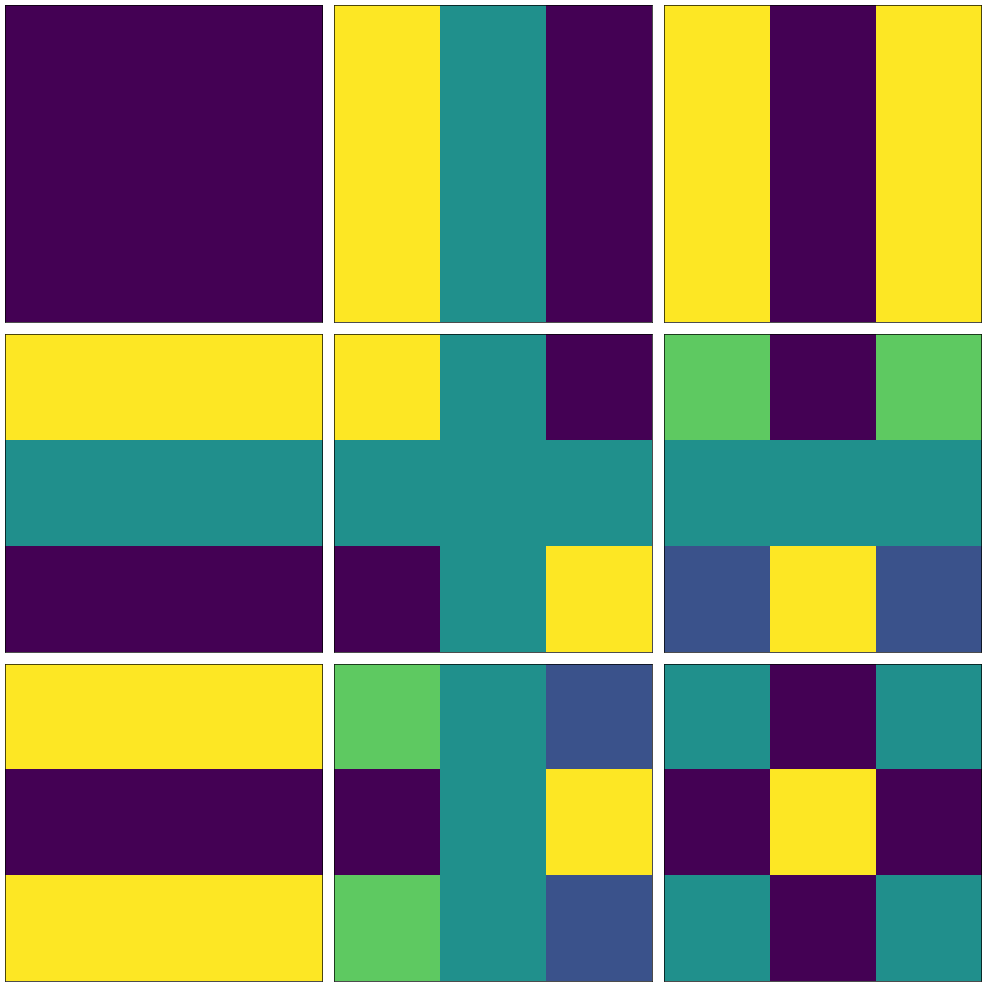

NameError: name 'dct_out' is not defined

In [2]:
from matplotlib.patches import PathPatch
from matplotlib.text import TextPath
from matplotlib.font_manager import FontProperties

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

bins = 8
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

'''vals = np.array([[dc_val, grad_x_val, grad_x2_val], 
 [grad_y_val, saddle_val, mix1_val],
 [grad_y2_val,mix2_val, laplace_val ]])'''


for i in range(0,3):
    for j in range(0,3):
        

        #x0,x1 = axes[i,j].get_xlim()
        #y0,y1 = 0, len(vals[0,0])
        dct_im = np.zeros((3,3))
        dct_im[i,j]=1
        #print(idct2(np.float16(dct_im)))
        #text = "%.4f" % np.mean(vals[i,j])
        axes[i,j].imshow(idct2(np.float16(dct_im)), cmap='viridis', aspect='auto',  interpolation='nearest', extent=(0, 255, 0, 255))
        
        
        '''font_properties = FontProperties(family="cmb10", style='normal', size=60)
        text_path = TextPath((0,0), text, prop=font_properties)
        
        # Calculate the center of the text
        text_bbox = text_path.get_extents()
        text_width = text_bbox.width
        text_height = text_bbox.height
        center_x = 127.5 - text_width / 2
        center_y = 127.5 - text_height / 2

        # Translate the text path to the centered position
        text_path = TextPath((center_x,center_y), text,  prop=font_properties)


        # Create a PathPatch with a thick white edge (border)
        border_patch = PathPatch(text_path, edgecolor='white', linewidth=10, facecolor='none', antialiased=True)
        axes[i,j].add_patch(border_patch)

        # Create a PathPatch with normal face color (for the main text)
        text_patch = PathPatch(text_path, edgecolor='none', facecolor='black')
        #axes[i,j].add_patch(text_patch)'''

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.tight_layout()
plt.savefig('figures/example_dct.pdf', dpi=600)

plt.show()

dct_out

In [126]:
vals.shape

(3, 3, 16100)

[0.5087088  0.1481139  0.16588397 0.055913   0.05679507 0.03046211
 0.01289524 0.01307248 0.00815551]
(0, 0)
(0, 1)
(1, 0)
(0, 2)
(2, 0)
(1, 1)
(1, 2)
(2, 1)
(2, 2)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


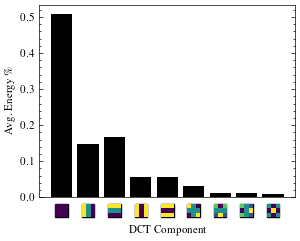

In [161]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

vals = np.mean(np.array([dc_val, grad_x_val, grad_y_val, grad_x2_val,  grad_y2_val,saddle_val, mix1_val,mix2_val, laplace_val ]), axis=-1)
print(vals)


fig, ax = plt.subplots()

bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0), (0,1), (1,0), (0,2), (2,0), (1,1), (1,2), (2,1), (2,2)]


for i, bar in enumerate(bars):
    # Load image

    dct_im = np.zeros((3,3))
    dct_im[pos[i]]=1
    print(pos[i])
    #print(idct2(np.float16(dct_im)))
    img = idct2(np.float16(dct_im))

    # Create OffsetImage object
    im = OffsetImage(img, zoom=3)  # Adjust zoom for image size

    # Get the x position of the bar's center
    x_position = bar.get_x() + bar.get_width() / 2

    # Place image below the x-axis label
    ab = AnnotationBbox(im, (x_position, 0), 
                        xybox=(0, -5),  # Adjust the second value for distance under the label
                        xycoords='data', 
                        boxcoords="offset points", 
                        pad=0, frameon=True, 
                        box_alignment=(0.5, 1))

    # Add image to the axes
    ax.add_artist(ab)
ax.set_xticklabels([''] * vals.shape[0])  # Set empty labels
ax.set_xlabel('DCT Component')
ax.xaxis.set_label_coords(0.5, -0.15)
ax.set_ylabel('Avg. Energy \%')
ax.tick_params(axis='x', which='both', length=0)

plt.savefig('figures/vgg16_dct.pdf', dpi=600)
plt.show()

In [158]:
np.sum(vals)

1.0